## 1. Data Preprocessing and Visualization of Observed PM2.5 Concentrations

In [2]:
from data.data_preprocessing import preprocess_data
lon, lat, idx_new, phi_obs, phi_reduce, s_obs, normalized_X, z, X_pred, normalized_X_pred = preprocess_data()

Total gridded cells: 7706
Observations: 604


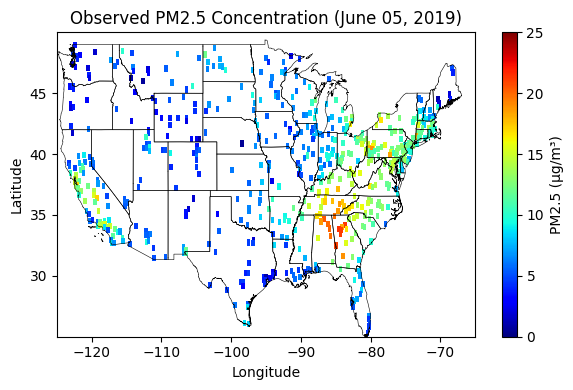

In [3]:
from utils.visualization import plot_pm25_map
plot_pm25_map(
    lon_vals=lon[idx_new],
    lat_vals=lat[idx_new],
    values=z[:, 0],
    title="Observed PM2.5 Concentration (June 05, 2019)"
)

## 2. Bayesian DeepKriging: Model Definition and Trial Training

In [4]:
from config import SEED, KL_WEIGHT, SAVE_DIR, RESULTS_DIR
from utils.bayesian_model import build_bayesian_pm25
from utils.training import train_bayesian_model, get_optimal_epoch

from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

inputs = np.hstack((normalized_X, phi_obs))
targets = z

# Train/Test Split
cov_trainval, cov_test, phi_trainval, phi_test, y_trainval, y_test = train_test_split(
    normalized_X, phi_obs, targets, test_size=0.2, random_state=SEED
)
# print("Train_val, test split complete.")

# Train/Validation Split
cov_train, cov_val, phi_train, phi_val, y_train, y_val = train_test_split(
    cov_trainval, phi_trainval, y_trainval, test_size=0.25, random_state=SEED
)
# print("Train, valid split complete.")

print("Train size:", len(cov_train), len(phi_train), len(y_train))
print("Validation size:", len(cov_val), len(phi_val), len(y_val))
print("Test size:", len(cov_test), len(phi_test), len(y_test))

Train size: 362 362 362
Validation size: 121 121 121
Test size: 121 121 121


In [5]:
model_test = build_bayesian_pm25(
    input_dim_phi=phi_train.shape[1],
    input_dim_cov=cov_train.shape[1], kl_weight=KL_WEIGHT)
model_test.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phi_input (InputLayer)         [(None, 1486)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          148700      ['phi_input[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 100)          0           ['dense[0][0]']                  
                                                                                                  
 dense_variational (DenseVariat  (None, 100)         20200       ['dropout[0][0]']                
 ional)                                                                                       

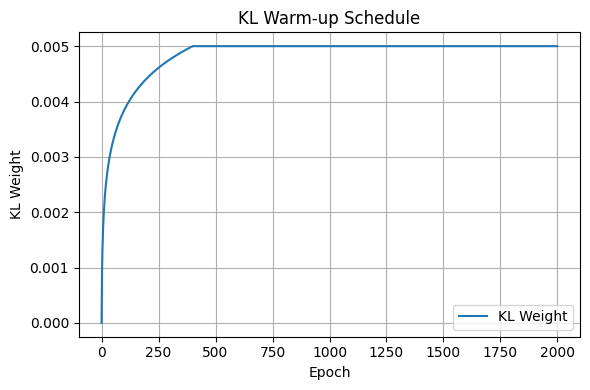

In [6]:
history = train_bayesian_model(
    model_test, cov_train, phi_train, y_train, cov_val, phi_val, y_val, plot_kl_warmup=True)

Best epoch: 1942


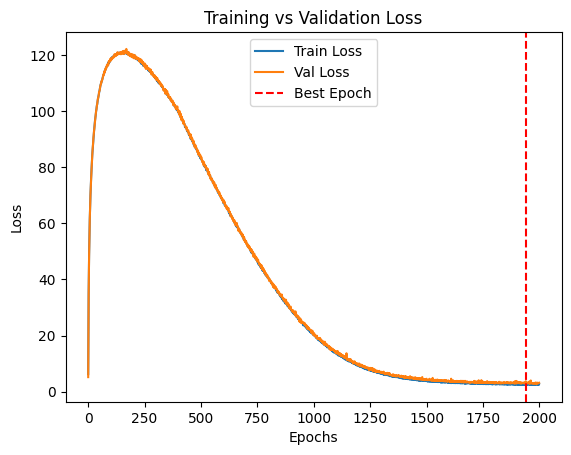

In [7]:
import matplotlib.pyplot as plt

best_epoch = get_optimal_epoch(history)
print(f"Best epoch: {best_epoch}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(best_epoch, linestyle='--', color='r', label='Best Epoch')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

## 3. 5-Fold Cross-Validation: Model Training and Evaluation

In [11]:
import os
from sklearn.model_selection import KFold
os.makedirs(SAVE_DIR, exist_ok=True)

def train_bayesian_cv(cov_trainval, phi_trainval, y_trainval, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    fold_no = 1
    saved_models = []

    for train_idx, val_idx in kfold.split(phi_trainval, y_trainval):
        model_path = os.path.join(SAVE_DIR, f"model_fold{fold_no}.h5")
        if os.path.exists(model_path):
            print(f"Skipping fold {fold_no}: model file already exists.")
            saved_models.append((model_path, None))
            fold_no += 1
            continue

        tf.keras.backend.clear_session()

        print(f"\n<Training fold: {fold_no}>")
        cov_train, cov_val = cov_trainval[train_idx], cov_trainval[val_idx]
        phi_train, phi_val = phi_trainval[train_idx], phi_trainval[val_idx]
        y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

        model = build_bayesian_pm25(
            input_dim_phi=phi_train.shape[1],
            input_dim_cov=cov_train.shape[1],
            kl_weight=KL_WEIGHT
        )
        history = train_bayesian_model(
            model, cov_train, phi_train, y_train, cov_val, phi_val, y_val, plot_kl_warmup=False)
        best_epoch = get_optimal_epoch(history)
        print(f"=> Best epoch for fold {fold_no}: {best_epoch}")
        
        model.save_weights(model_path)
        saved_models.append((model_path, best_epoch))
        fold_no += 1

    return saved_models

In [12]:
print("Running 5-fold CV with best-epoch saving...")
saved_models = train_bayesian_cv(
    cov_trainval, phi_trainval, y_trainval, n_splits=5)

Running 5-fold CV with best-epoch saving...

<Training fold: 1>
Restoring best weights from epoch 1559

Early stopping at epoch 1639
Best model was at epoch 1559
=> Best epoch for fold 1: 1559

<Training fold: 2>
Restoring best weights from epoch 1475

Early stopping at epoch 1555
Best model was at epoch 1475
=> Best epoch for fold 2: 1475

<Training fold: 3>
Restoring best weights from epoch 1571

Early stopping at epoch 1651
Best model was at epoch 1571
=> Best epoch for fold 3: 1571

<Training fold: 4>
Restoring best weights from epoch 1540

Early stopping at epoch 1620
Best model was at epoch 1540
=> Best epoch for fold 4: 1540

<Training fold: 5>
Restoring best weights from epoch 1529

Early stopping at epoch 1609
Best model was at epoch 1529
=> Best epoch for fold 5: 1529


In [13]:
from utils.evaluation import evaluate_mc

print("Evaluation with NLL, RMSE, and Calibration curve...")
mean_preds, loc_list, scale_list, rmse, nll, crps = evaluate_mc(
    saved_models, cov_test, phi_test, y_test, n_samples=200
)

Evaluation with NLL, RMSE, and Calibration curve...

Evaluation Summary (Monte Carlo)
RMSE: 1.853
NLL(LogNormal): 2.469
CRPS: 1.246


## 4. Final Prediction and Uncertainty Estimation

In [14]:
from utils.prediction import predict_all_folds
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Predicting over entire grid using all trained folds...")
all_samples, mean_preds_all, std_preds_all = predict_all_folds(
    saved_models, normalized_X_pred, phi_reduce, n_samples=200
)

Predicting over entire grid using all trained folds...
Prediction complete.
Prediction shape: (7706,)


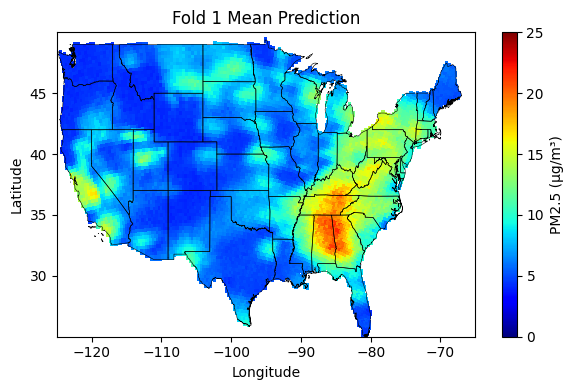

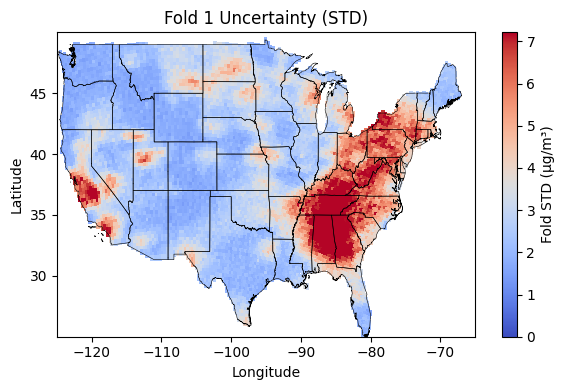

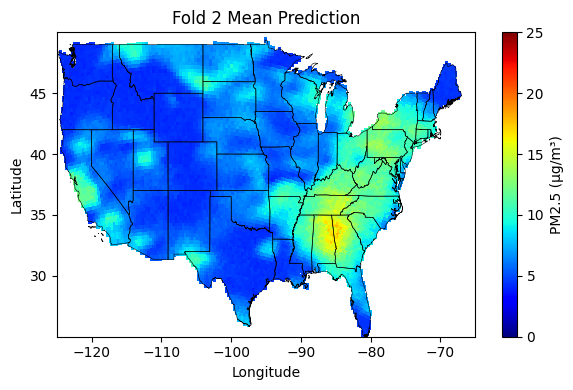

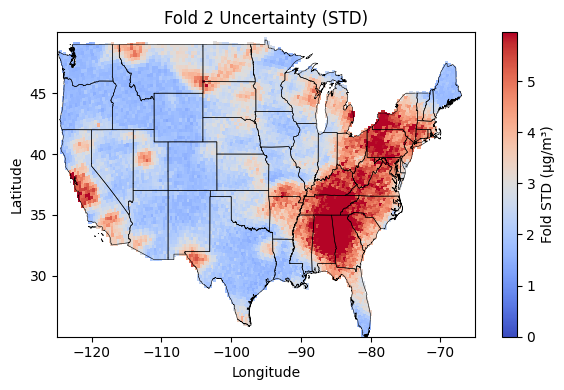

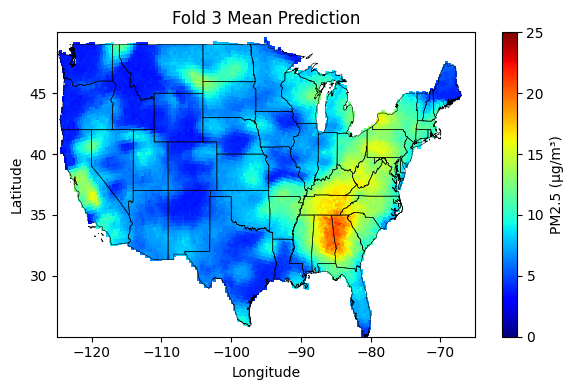

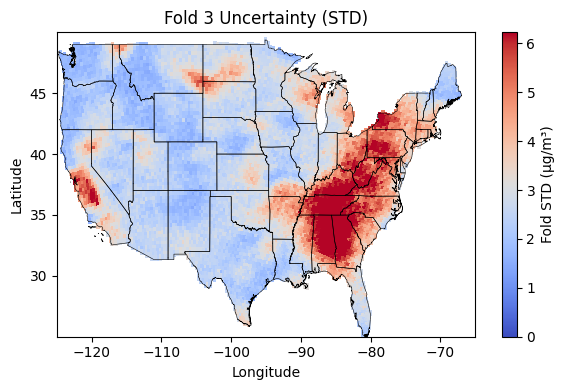

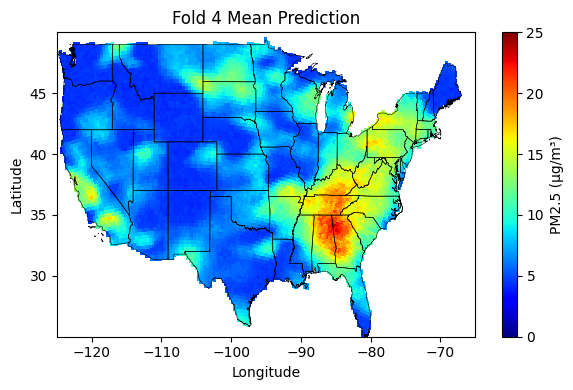

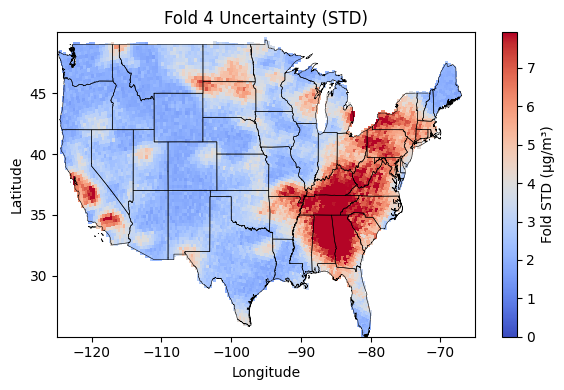

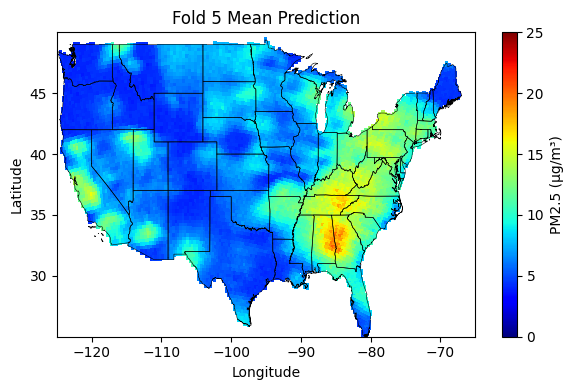

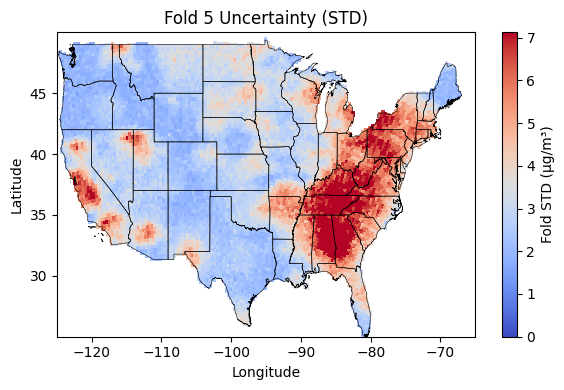

In [15]:
import os
import numpy as np
from utils.visualization import plot_pm25_map

n_folds = 5
for i in range(1, n_folds + 1):
    samples = np.load(f"{RESULTS_DIR}/fold{i}_samples.npy")
    fold_mean = samples.mean(axis=0)
    plot_pm25_map(
        lon_vals=lon,
        lat_vals=lat,
        values=fold_mean,
        title=f"Fold {i} Mean Prediction"
    )
    plt.savefig(os.path.join(RESULTS_DIR, f"fold{i}_mean_prediction_map.png"))
    plt.close()

    fold_std = samples.std(axis=0)
    plot_pm25_map(
        lon_vals=lon,
        lat_vals=lat,
        values=fold_std,
        title=f"Fold {i} Uncertainty (STD)",
        vmax=np.percentile(fold_std, 95),
        label="Fold STD (µg/m³)",
        cmap="coolwarm"
    )
    plt.savefig(os.path.join(RESULTS_DIR, f"fold{i}_std_map.png"))
    plt.close()

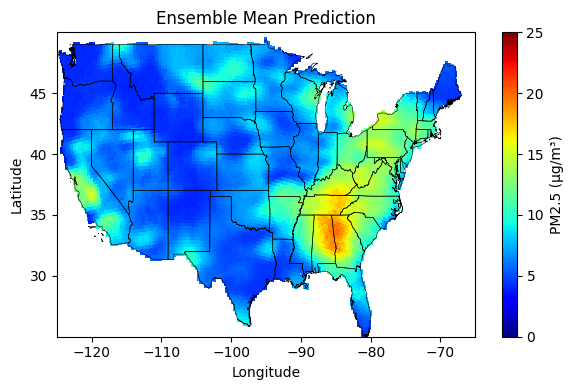

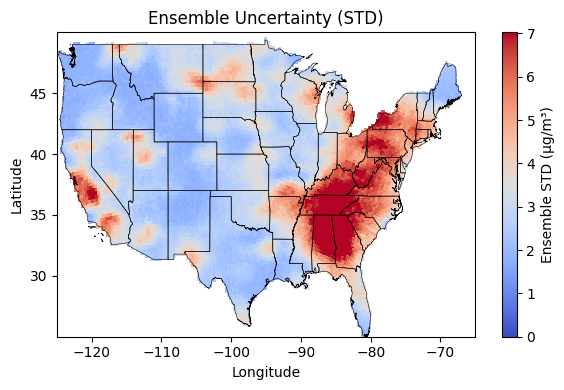

In [16]:
plot_pm25_map(
    lon_vals=lon,
    lat_vals=lat,
    values=mean_preds_all,
    title="Ensemble Mean Prediction"
)
plt.savefig(os.path.join(RESULTS_DIR, "ensemble_mean_map.png"))
plt.close()

plot_pm25_map(
    lon_vals=lon,
    lat_vals=lat,
    values=std_preds_all,
    title="Ensemble Uncertainty (STD)",
    vmax=np.percentile(std_preds_all, 95),
    label="Ensemble STD (µg/m³)",
    cmap="coolwarm"
)
plt.savefig(os.path.join(RESULTS_DIR, "ensemble_std_map.png"))
plt.close()

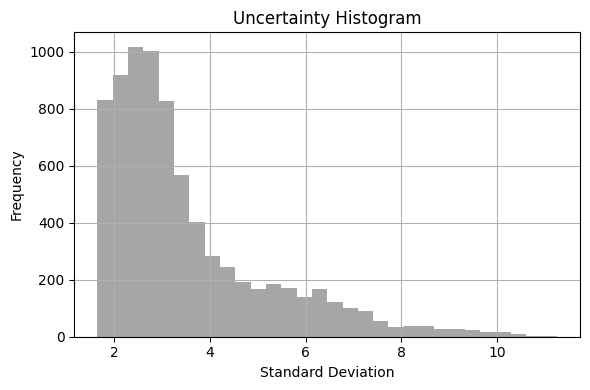

In [17]:
plt.figure(figsize=(6, 4))
plt.hist(std_preds_all, bins=30, color='gray', alpha=0.7)
plt.title("Uncertainty Histogram")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()